In [1]:
!pip install pandas numpy openpyxl requests lightgbm


In [2]:
!pip install scikit-learn


In [3]:
import pandas as pd
import numpy as np
import pickle
import requests
from io import BytesIO

In [4]:
GITHUB_TEST_XLSX_URL = "https://github.com/samoletpanfilov/reinforcement_task/raw/master/data/test.xlsx"

response = requests.get(GITHUB_TEST_XLSX_URL)
test_data = pd.read_excel(BytesIO(response.content))

test_data['dt'] = pd.to_datetime(test_data['dt'])

# Убеждаемся, что данные отсортированы по времени
test_data = test_data.sort_values(by='dt')

# Добавляем новые признаки
test_data["year"] = test_data["dt"].dt.year
test_data["month"] = test_data["dt"].dt.month
test_data["quarter"] = test_data["dt"].dt.quarter
test_data["day_of_month"] = test_data["dt"].dt.day
test_data["day_of_week"] = test_data["dt"].dt.weekday 

# Создаем копию
test_data = test_data.copy()


In [5]:
import pickle
from scipy.stats import boxcox

test_data = test_data.copy()

test_data["dt"] = pd.to_datetime(test_data["dt"], errors="coerce")
test_data = test_data.sort_values(by="dt") 

# 🔹 Генерация временных фичей
test_data["year"] = test_data["dt"].dt.year
test_data["month"] = test_data["dt"].dt.month
test_data["quarter"] = test_data["dt"].dt.quarter
test_data["day_of_month"] = test_data["dt"].dt.day
test_data["day_of_week"] = test_data["dt"].dt.weekday

if "Цена на арматуру" in test_data.columns:
    test_data["rolling_std"] = test_data["Цена на арматуру"].rolling(5, min_periods=1).std()
    test_data["normalized_price"] = (test_data["Цена на арматуру"] - test_data["Цена на арматуру"].min()) / (test_data["Цена на арматуру"].max() - test_data["Цена на арматуру"].min())
    test_data["log_normalized_price"] = np.log1p(test_data["normalized_price"])
    test_data["stationary_price"] = test_data["Цена на арматуру"].diff().fillna(0)
    test_data["boxcox_price"], _ = boxcox(test_data["Цена на арматуру"].clip(lower=0.01))
    test_data["diff_boxcox_price"] = test_data["boxcox_price"].diff().fillna(0)

    # 🔹 Лаги (без заполнения)
    lag_features = 12
    for i in range(1, lag_features + 1):
        test_data[f"lag_{i}"] = test_data["Цена на арматуру"].shift(i)

    # 🔹 Скользящие средние
    test_data["rolling_mean_3"] = test_data["Цена на арматуру"].rolling(3, min_periods=1).mean()
    test_data["rolling_mean_6"] = test_data["Цена на арматуру"].rolling(6, min_periods=1).mean()
    test_data["rolling_mean_12"] = test_data["Цена на арматуру"].rolling(12, min_periods=1).mean()

    # 🔹 Экспоненциальные средние
    test_data["ewm_6"] = test_data["Цена на арматуру"].ewm(span=6, adjust=False).mean()
    test_data["ewm_12"] = test_data["Цена на арматуру"].ewm(span=12, adjust=False).mean()

    # 🔹 Разности
    test_data["diff_1"] = test_data["Цена на арматуру"].diff(1)
    test_data["diff_3"] = test_data["Цена на арматуру"].diff(3)

# Удаляем ненужные колонки
features = test_data.drop(columns=["dt"], errors="ignore")

In [6]:
with open("lightgbm_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Получаем признаки, которые использовались при обучении
model_features = set(model.feature_name())

for feature in model_features:
    if feature not in features:
        features[feature] = 0

features = features[list(model_features)]

test_data["predicted_price"] = model.predict(features)

rolling_mean = test_data["Цена на арматуру"].rolling(6, min_periods=1).mean()

def calculate_weeks(price, avg_price):
    """Функция для расчёта количества недель закупки"""
    if price < avg_price * 0.95:
        return 12  # Цена низкая, закупаем на 12 недель
    elif price < avg_price * 1.05:
        return 6  # Цена в норме, закупаем на 6 недель
    else:
        return 3  # Цена высокая, закупаем только на 3 недели

test_data["N"] = [calculate_weeks(p, avg) for p, avg in zip(test_data["predicted_price"], rolling_mean)]

output_path = "test.xlsx"
test_data.to_excel(output_path, index=False)

print(f"Файл {output_path} сохранён с прогнозом N.")

Файл test.xlsx сохранён с прогнозом N.


📊 Оценка точности прогноза цены:
🔹 MAE  (Средняя абсолютная ошибка)  = 3415.80
🔹 RMSE (Среднеквадратичная ошибка) = 5123.53
🔹 MAPE (Средняя процентная ошибка) = 7.26%

Рекомендованное количество недель для закупки арматуры: 8 недель


c:\Users\User\Desktop\intensive_3\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


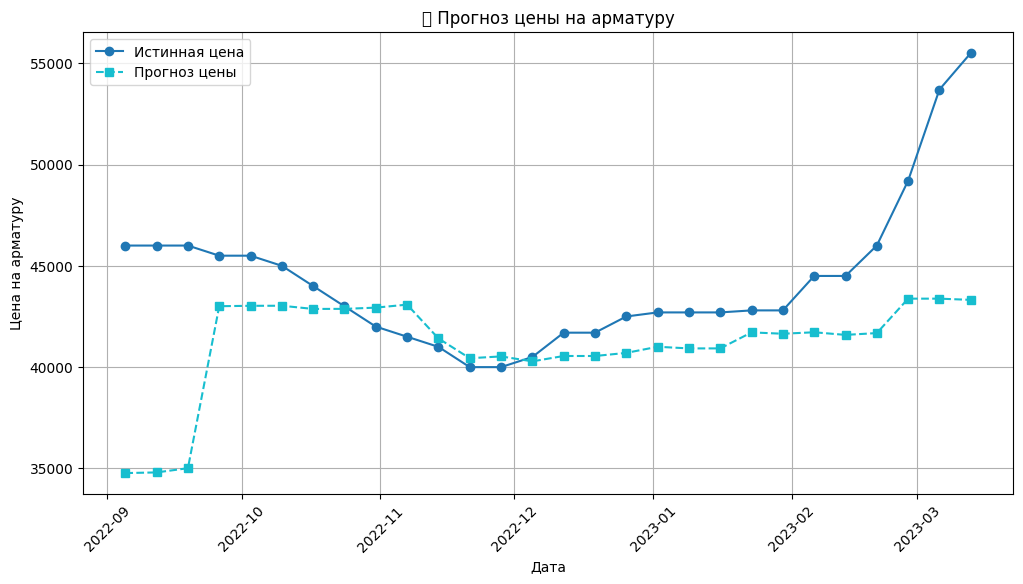

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

GITHUB_TEST_XLSX_URL = "https://github.com/samoletpanfilov/reinforcement_task/raw/master/data/test.xlsx"
original_data = pd.read_excel(GITHUB_TEST_XLSX_URL)

predicted_data = pd.read_excel("test.xlsx")

if {"Цена на арматуру", "dt"}.issubset(original_data.columns) and {"predicted_price", "N", "dt"}.issubset(predicted_data.columns):

    merged_data = original_data[["dt", "Цена на арматуру"]].merge(
        predicted_data[["dt", "predicted_price", "N"]], on="dt", how="inner"
    )

    y_true_price = merged_data["Цена на арматуру"]
    y_pred_price = merged_data["predicted_price"]

    mae_price = mean_absolute_error(y_true_price, y_pred_price)
    rmse_price = np.sqrt(mean_squared_error(y_true_price, y_pred_price))
    mape_price = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100

    print(f"📊 Оценка точности прогноза цены:")
    print(f"🔹 MAE  (Средняя абсолютная ошибка)  = {mae_price:.2f}")
    print(f"🔹 RMSE (Среднеквадратичная ошибка) = {rmse_price:.2f}")
    print(f"🔹 MAPE (Средняя процентная ошибка) = {mape_price:.2f}%")

    # Вывод рекомендованного количества недель закупки
    avg_weeks = int(round(merged_data["N"].mean()))
    print(f"\nРекомендованное количество недель для закупки арматуры: {avg_weeks} недель")

    # Визуализация прогноза цены
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data["dt"], y_true_price, label="Истинная цена", marker="o", color="tab:blue")
    plt.plot(merged_data["dt"], y_pred_price, label="Прогноз цены", marker="s", linestyle="dashed", color="tab:cyan")

    plt.xlabel("Дата")
    plt.ylabel("Цена на арматуру")
    plt.title("📈 Прогноз цены на арматуру")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

else:
    print("⚠ Нет необходимых колонок для анализа.")
